# Dependencies

In [ ]:
import kagglehub
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

import torchvision
import torchvision.transforms as transforms
import timm

import os
import random
from tqdm.notebook import tqdm
import copy

Dataset link source: https://www.kaggle.com/datasets/nirmalsankalana/apple-tree-leaf-disease-dataset

In [ ]:
# download kaggle dataset and move it to the folder
path = kagglehub.dataset_download("nirmalsankalana/apple-tree-leaf-disease-dataset")
print("Path to dataset files:", path)
shutil.move(path, "/content/drive/MyDrive/Apple_tree_disease")

100%|██████████| 179M/179M [00:06<00:00, 27.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nirmalsankalana/apple-tree-leaf-disease-dataset/versions/1


'/content/drive/MyDrive/Apple_tree_disease'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
def train_valid_data_split(source_dir:str, output_dir:str, train_ratio:float):
  for split in ["train", "valid"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

  for disease in os.listdir(source_dir):
      disease_path = os.path.join(source_dir, disease)
      if not os.path.isdir(disease_path):  # Skip non-folder files
          continue

      # get full image disease path name
      images = os.listdir(disease_path)
      random.shuffle(images)

      train_count = int(len(images) * train_ratio)
      train_images = images[:train_count]
      valid_images = images[train_count:]

      # move images to respective directories
      for split, image_list in zip(["train", "valid"], [train_images, valid_images]):
          split_dir = os.path.join(output_dir, split, disease)
          os.makedirs(split_dir, exist_ok=True)
          for img in image_list:
              shutil.copy(os.path.join(disease_path, img), os.path.join(split_dir, img))

source_dir = "/content/drive/MyDrive/Apple_tree_disease"
output_dir = "/content/drive/MyDrive/Splited_AppleData"
train_ratio = 0.8
train_valid_data_split(source_dir, output_dir, train_ratio)

# Prepare data for training deep learning model

In [ ]:
class DiseaseDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
     return self.data[index]

  @property
  def classes(self):
    return self.data.classes

In [ ]:
train_dir = "/content/drive/MyDrive/Splited_AppleData/train"
valid_dir = "/content/drive/MyDrive/Splited_AppleData/valid"

train_dataset = DiseaseDataset(train_dir)
valid_dataset = DiseaseDataset(valid_dir)

In [ ]:
# can see length of data in train/valid
print(len(train_dataset))
print(len(valid_dataset))

1312
329


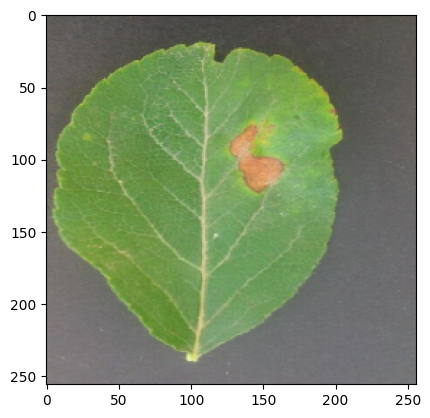

In [ ]:
image, img_label = train_dataset[3]

plt.imshow(image)
plt.show()

In [ ]:
# for image above we have next class (label)
img_label

0

In [ ]:
# but we can see what class exactly is
labels = {v: k for k, v in ImageFolder(train_dir).class_to_idx.items()}
print(labels)

{0: 'Alternaria leaf spot', 1: 'Brown spot', 2: 'Gray spot', 3: 'Healthy leaf', 4: 'Rust'}


In [ ]:
# make simple transform and implement it to our data again
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
# again read our data with transform and then implement batch_size
train_dir = "/content/drive/MyDrive/Splited_AppleData/train"
valid_dir = "/content/drive/MyDrive/Splited_AppleData/valid"

train_dataset = DiseaseDataset(train_dir, transform=transform)
valid_dataset = DiseaseDataset(valid_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [ ]:
# here we get tensor
train_dataset[0]

(tensor([[[0.3569, 0.3686, 0.3608,  ..., 0.2471, 0.2392, 0.2431],
          [0.3686, 0.3725, 0.3686,  ..., 0.2549, 0.2471, 0.2431],
          [0.3725, 0.3843, 0.3843,  ..., 0.2627, 0.2706, 0.2706],
          ...,
          [0.6157, 0.6196, 0.6078,  ..., 0.4902, 0.4941, 0.5059],
          [0.6275, 0.6235, 0.6196,  ..., 0.4980, 0.5020, 0.4980],
          [0.6353, 0.6353, 0.6275,  ..., 0.5020, 0.5020, 0.4941]],
 
         [[0.3569, 0.3686, 0.3608,  ..., 0.2549, 0.2431, 0.2392],
          [0.3686, 0.3725, 0.3686,  ..., 0.2627, 0.2510, 0.2431],
          [0.3725, 0.3843, 0.3843,  ..., 0.2667, 0.2784, 0.2745],
          ...,
          [0.5843, 0.5882, 0.5765,  ..., 0.4863, 0.4902, 0.4980],
          [0.5961, 0.5922, 0.5882,  ..., 0.4941, 0.5020, 0.4980],
          [0.6039, 0.6039, 0.5961,  ..., 0.4980, 0.5020, 0.4980]],
 
         [[0.3490, 0.3608, 0.3529,  ..., 0.2510, 0.2431, 0.2510],
          [0.3608, 0.3647, 0.3608,  ..., 0.2588, 0.2471, 0.2431],
          [0.3647, 0.3765, 0.3765,  ...,

# CNN model from scratch

In [ ]:
# make some CNN from scratch
class NeuralNet(nn.Module):
  def __init__(self, number_classes=5):
     super(NeuralNet, self).__init__()

     self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
     self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
     self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5)
     self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5)

     self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
     self.relu = nn.ReLU()

     self.fc1 = nn.Linear(4 * 4 * 48, 120)
     self.fc2 = nn.Linear(120, 84)
     self.fc3 = nn.Linear(84, number_classes)

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))  # 128-5+1 -> 62
    x = self.pool(self.relu(self.conv2(x)))  # 62-5+1  -> 29
    x = self.pool(self.relu(self.conv3(x)))  # 29-4+1  -> 13
    x = self.pool(self.relu(self.conv4(x)))  # 13-4+1  -> 5

    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
# determine the model and some attributes
model = NeuralNet().to(device)

train_losses, valid_losses, train_acc, valid_acc = [], [], [], []
epochs = 25
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

dataset_sizes = {
    "train": len(train_dataset),
    "valid": len(valid_dataset)
}

In [ ]:
def cnn_training_loop(model, epoch, epochs, best_acc, best_model_weights,
                      train_losses, train_acc, valid_losses, valid_acc):
  for phase in ["train", "valid"]:
    if phase == "train":
      model.train()
      data_loader = train_loader
      desc = "Training loop"
    else:
      model.eval()
      data_loader = valid_loader
      desc = "Validation loop"

    running_loss = 0
    running_corrects = 0

    for images, labels in tqdm(data_loader, desc=desc):
      images, labels = images.to(device), labels.to(device)

      with torch.set_grad_enabled(phase == "train"):
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize only if in training phase
        if phase == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss /  dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    if phase == "train":
      train_losses.append(epoch_loss)
      train_acc.append(epoch_acc.item())
    else:
      valid_losses.append(epoch_loss)
      valid_acc.append(epoch_acc.item())

    print(f"Epoch {epoch+1}/{epochs} - {phase} loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    print("\n")
    if phase == "valid" and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_weights = copy.deepcopy(model.state_dict())
  return best_acc, best_model_weights

In [ ]:
best_acc = 0
best_model_weights = 0
for epoch in range(epochs):
  best_acc, best_model_weights = cnn_training_loop(model,
                                                   epoch,
                                                   epochs,
                                                   best_acc,
                                                   best_model_weights,
                                                   train_losses,
                                                   train_acc,
                                                   valid_losses,
                                                   valid_acc)

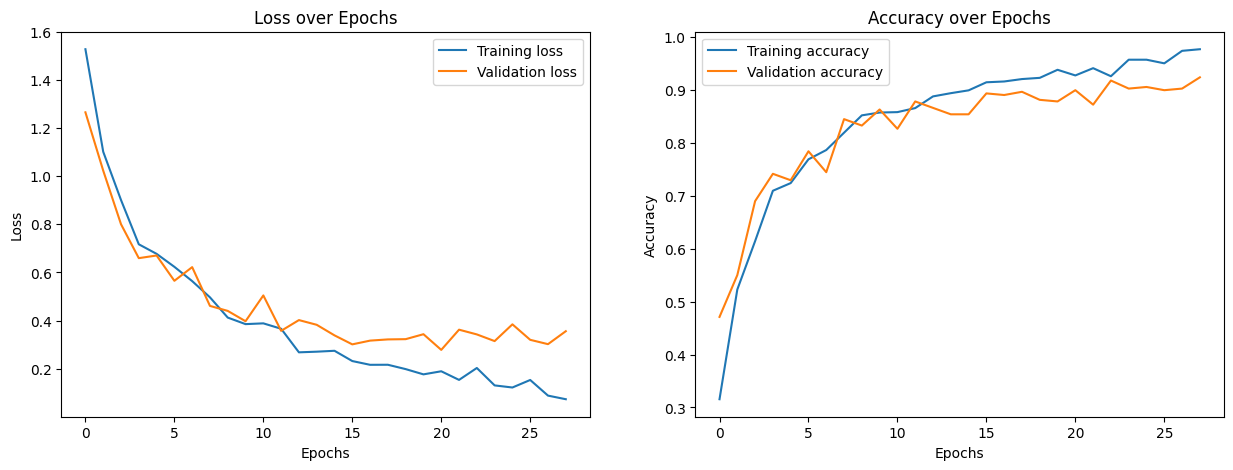

In [ ]:
# as we finished train our model let's see some plots
f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_losses, label="Training loss")
ax[0].plot(valid_losses, label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss over Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(train_acc, label="Training accuracy")
ax[1].plot(valid_acc, label="Validation accuracy")
ax[1].legend()
ax[1].set_title("Accuracy over Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

So, we see that in general we have pretty good result, but also can notice on graphs above a little overfitting. We can try to deal with that using dropout, batch normalization and other regularization thing or just use pre-trained model.

In [ ]:
torch.save(best_model_weights, "first_model_weights.pth")

In [ ]:
model.load_state_dict(torch.load('first_model_weights.pth', weights_only=True))

<All keys matched successfully>

In [ ]:
# best_model_weights
best_acc.item()

0.9240121580547113

So in this model we get good result but still get overfitting what is not good. Let's try use pre-trained model for task.

# Pre-trained CNN model

In [ ]:
class LeavesDiseaseClassifierB0(nn.Module):
  def __init__(self, num_classes=5):
    super(LeavesDiseaseClassifierB0, self).__init__()
    self.base_model = timm.create_model("efficientnet_b0", pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    enet_out_size = 1280
    self.classifier = nn.Linear(enet_out_size, num_classes)

  def forward(self, x):
    x = self.features(x)
    output = self.classifier(x)
    return output

In [ ]:
model_2 = LeavesDiseaseClassifierB0().to(device)

train_losses_2, valid_losses_2, train_acc_2, valid_acc_2 = [], [], [], []
# as we get more powerful model i remove some of epochs for faster training
epochs = 15
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

dataset_sizes = {
    "train": len(train_dataset),
    "valid": len(valid_dataset)
}

In [ ]:
best_acc_2 = 0
best_model_weights_2 = 0
for epoch in range(epochs):
  best_acc_2, best_model_weights_2 = cnn_training_loop(model_2,
                                                       epoch,
                                                       epochs,
                                                       best_acc_2,
                                                       best_model_weights_2,
                                                       train_losses_2,
                                                       train_acc_2,
                                                       valid_losses_2,
                                                       valid_acc_2)


Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/15 - train loss: 0.3501 Acc: 0.8948




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/15 - valid loss: 0.2558 Acc: 0.9210




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2/15 - train loss: 0.1561 Acc: 0.9505




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/15 - valid loss: 0.0854 Acc: 0.9848




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3/15 - train loss: 0.0542 Acc: 0.9840




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/15 - valid loss: 0.0786 Acc: 0.9757




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4/15 - train loss: 0.0667 Acc: 0.9802




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/15 - valid loss: 0.0739 Acc: 0.9726




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5/15 - train loss: 0.0851 Acc: 0.9802




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/15 - valid loss: 0.1029 Acc: 0.9574




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6/15 - train loss: 0.0986 Acc: 0.9741




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/15 - valid loss: 0.1275 Acc: 0.9635




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7/15 - train loss: 0.0752 Acc: 0.9840




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/15 - valid loss: 0.0893 Acc: 0.9666




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8/15 - train loss: 0.0439 Acc: 0.9870




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/15 - valid loss: 0.0853 Acc: 0.9726




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9/15 - train loss: 0.0529 Acc: 0.9825




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/15 - valid loss: 0.0150 Acc: 0.9970




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10/15 - train loss: 0.0151 Acc: 0.9954




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/15 - valid loss: 0.0479 Acc: 0.9939




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11/15 - train loss: 0.0311 Acc: 0.9901




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/15 - valid loss: 0.0466 Acc: 0.9878




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12/15 - train loss: 0.0102 Acc: 0.9954




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/15 - valid loss: 0.0342 Acc: 0.9909




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13/15 - train loss: 0.0120 Acc: 0.9970




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/15 - valid loss: 0.0467 Acc: 0.9818




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14/15 - train loss: 0.0229 Acc: 0.9939




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/15 - valid loss: 0.0474 Acc: 0.9818




Training loop:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15/15 - train loss: 0.0499 Acc: 0.9878




Validation loop:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/15 - valid loss: 0.0715 Acc: 0.9787




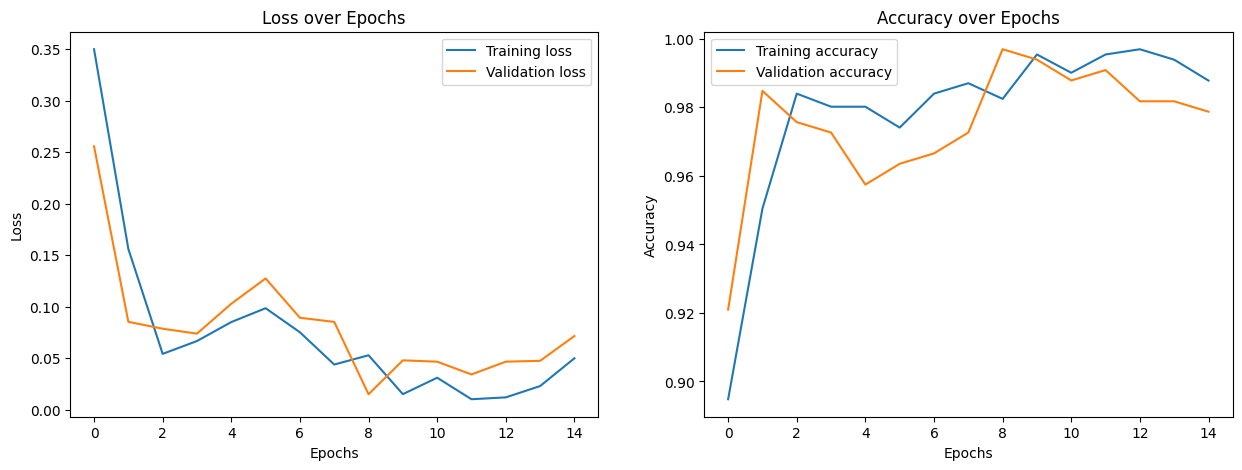

In [ ]:
# as we finished train our model let's see some plots
f, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_losses_2, label="Training loss")
ax[0].plot(valid_losses_2, label="Validation loss")
ax[0].legend()
ax[0].set_title("Loss over Epochs")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(train_acc_2, label="Training accuracy")
ax[1].plot(valid_acc_2, label="Validation accuracy")
ax[1].legend()
ax[1].set_title("Accuracy over Epochs")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
plt.show()

So after training and validating data on pre-trained model we get pretty good result. But also we see that we don't need more then 8 epoch, because after that we have consistent decrease. This model better than mine raw CNN model, but mine train faster then that.

In [ ]:
# best_model_weights_2
print(f"Pre-trained model accuracy: {best_acc_2.item():.4f}")

Pre-trained model accuracy: 0.9970


In [ ]:
torch.save(best_model_weights_2, "pre_trained_model_weights.pth")

In [ ]:
model_2.load_state_dict(torch.load('pre_trained_model_weights.pth', weights_only=True))

<All keys matched successfully>

# Predict on the data not from dataset

In [ ]:
new_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def load_image(image_path):
  image = Image.open(image_path)
  image = new_transform(image)
  image = image.unsqueeze(0)

  return image

image_paths = ["/content/example_1_alt.jpg", "/content/example_2_alt.jpg",
               "/content/example_3_brown.jpg", "/content/example_4_brown.jpg",
               "/content/example_5_rust.jpg", "/content/example_7_gray.jpg"]
images  = [load_image(img) for img in image_paths]

data = []
for mod in [model, model_2]:
  mod.eval()
  with torch.no_grad():
    for i, image in enumerate(images):
      output = mod(image)
      _, predicted = torch.max(output, 1)
      data.append(labels[predicted.item()])
      # print(f"# {i+1} - prediction: {labels[predicted.item()]}")

In [ ]:
df = pd.DataFrame({
    "actual_labels": ["Alternaria leaf spot", "Alternaria leaf spot",
                      "Brown spot", "Brown spot", "Rust", "Gray spot"],
    "predicted_model": data[:6],
    "predicted_model_2": data[6:],
})

df

,actual_labels,predicted_model,predicted_model_2
0,Alternaria leaf spot,Alternaria leaf spot,Gray spot
1,Alternaria leaf spot,Alternaria leaf spot,Gray spot
2,Brown spot,Alternaria leaf spot,Alternaria leaf spot
3,Brown spot,Alternaria leaf spot,Alternaria leaf spot
4,Rust,Brown spot,Alternaria leaf spot
5,Gray spot,Gray spot,Gray spot


In the end we get pretty poor result on the real data from internet. See that first model a little bit better, but get only 3/6. This result is most likely due to the fact that the source data either does not correspond to the real ones, although within the boundaries of the provided dataset the model shows itself to be excellent.